# Dataset exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

In [2]:
# Load dataset
df = pd.read_csv('data/ts2024.csv', parse_dates=['DateTime'])

# Display initial info
print("Initial dataset info:")
print(df.info())
print(df.describe())

Initial dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  17544 non-null  object 
 1   Date      17544 non-null  object 
 2   Hour      17544 non-null  int64  
 3   X         16800 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 548.4+ KB
None
               Hour             X
count  17544.000000  16800.000000
mean      11.500000      0.046320
std        6.922384      0.048945
min        0.000000      0.000000
25%        5.750000      0.018200
50%       11.500000      0.036800
75%       17.250000      0.053800
max       23.000000      0.450000


In [3]:
# Check for missing and zero values
missing = df.isna().sum()
zeros = (df['X'] == 0).sum()
print(f"Missing values:\n{missing}")
print(f"Zero values in 'X': {zeros}")

Missing values:
DateTime      0
Date          0
Hour          0
X           744
dtype: int64
Zero values in 'X': 107


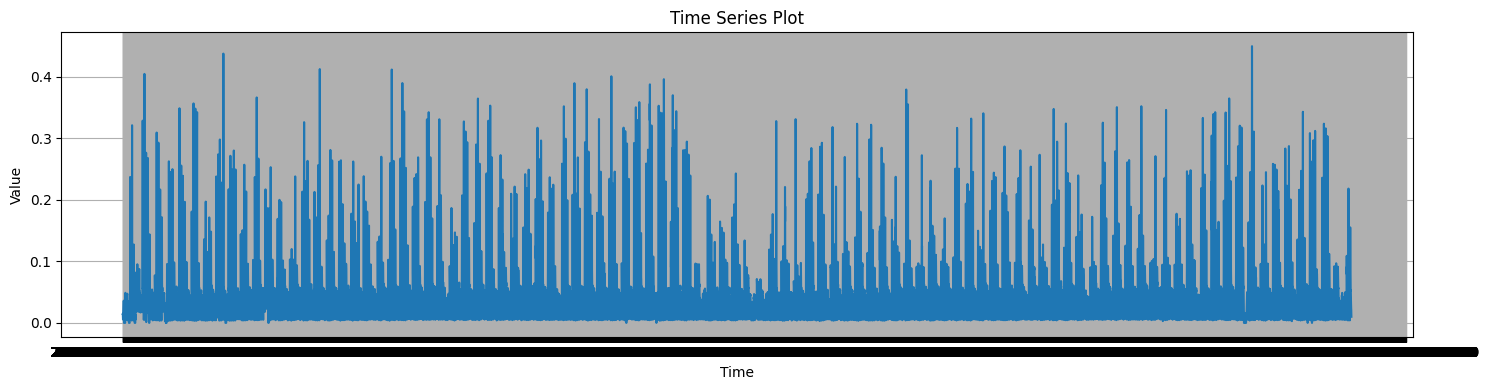

In [4]:
# Plot the time series
plt.figure(figsize=(15, 4))
plt.plot(df['DateTime'], df['X'])
plt.title("Time Series Plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
import plotly.express as px

# Fast interactive plot with Plotly
fig = px.line(df, x='DateTime', y='X', title="Time Series Plot")
fig.update_layout(xaxis_title="Time", yaxis_title="Value")
fig.show()

In [6]:
df

,DateTime,Date,Hour,X
0,2015-01-01,2015-01-01,0,0.0146
1,2015-01-01 01:00:00,2015-01-01,1,0.0148
2,2015-01-01 02:00:00,2015-01-01,2,0.0101
3,2015-01-01 03:00:00,2015-01-01,3,0.0060
4,2015-01-01 04:00:00,2015-01-01,4,0.0055
...,...,...,...,...
17539,2016-12-31 19:00:00,2016-12-31,19,NaN
17540,2016-12-31 20:00:00,2016-12-31,20,NaN
17541,2016-12-31 21:00:00,2016-12-31,21,NaN
17542,2016-12-31 22:00:00,2016-12-31,22,NaN


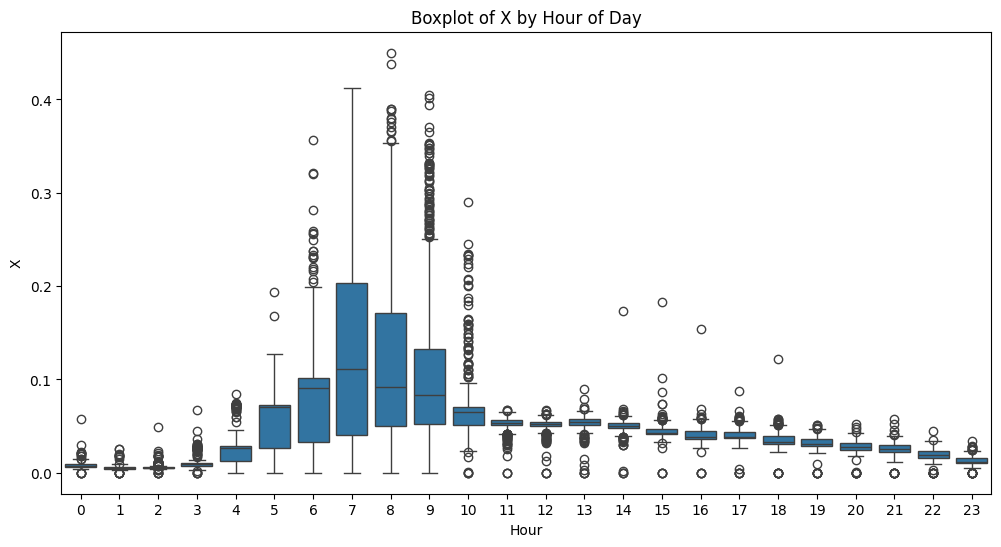

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x=df['Hour'], y=df['X'])  # Replace 'df' and 'X' if different
plt.title('Boxplot of X by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('X')
plt.show()

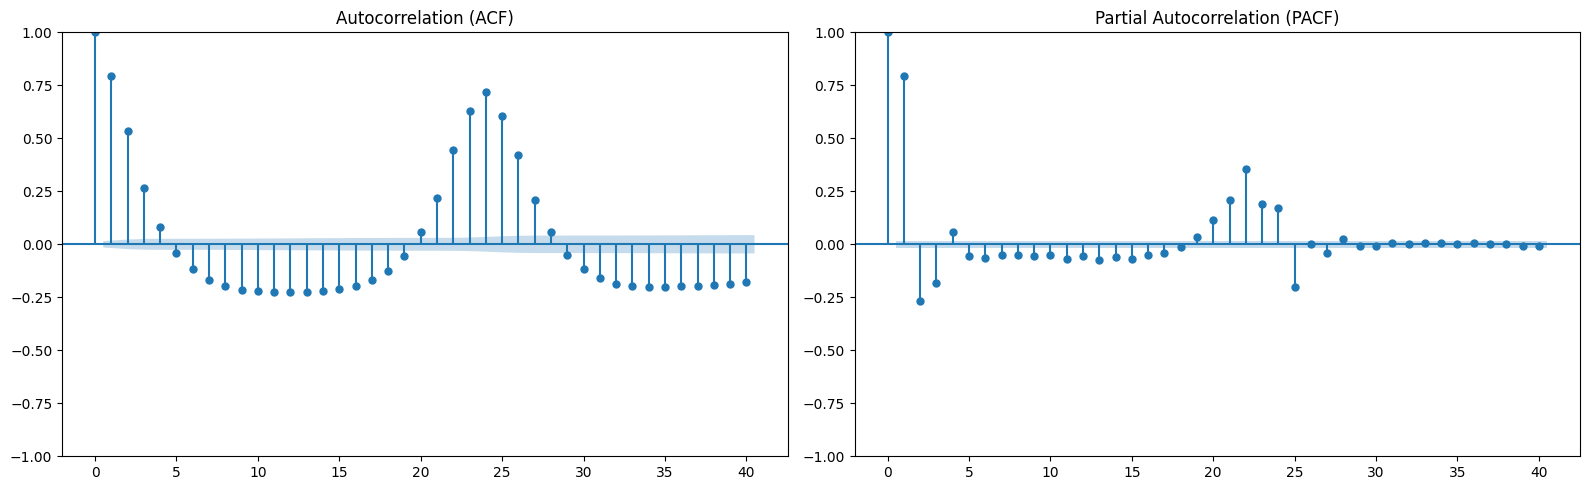

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Drop missing values and ensure series is numeric
series = df['X'].dropna().astype(float)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(series, lags=40, ax=ax[0])
ax[0].set_title('Autocorrelation (ACF)')

plot_pacf(series, lags=40, ax=ax[1], method='ywm')
ax[1].set_title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()


In [9]:
from statsmodels.tsa.stattools import adfuller

# Make sure your series is clean (no NaNs, numeric)
adf_result = adfuller(series.dropna())

print("Augmented Dickey-Fuller Test")
print(f"ADF Statistic : {adf_result[0]:.4f}")
print(f"p-value       : {adf_result[1]:.4f}")
for key, value in adf_result[4].items():
    print(f"Critical Value {key} : {value:.4f}")

Augmented Dickey-Fuller Test
ADF Statistic : -15.7110
p-value       : 0.0000
Critical Value 1% : -3.4307
Critical Value 5% : -2.8617
Critical Value 10% : -2.5669


### Outlier removal

In [10]:
# Split training and test sets
train = df.iloc[:-744].copy()
test = df.iloc[-744:].copy()

# Compute thresholds
lower = train['X'].quantile(0.01)
upper = train['X'].quantile(0.99)
median = train['X'].median()

# Replace outliers in training set
train.loc[train['X'] < lower, 'X'] = median
train.loc[train['X'] > upper, 'X'] = median

# Recombine cleaned training and untouched test set
df['X_cleaned'] = pd.concat([train['X'], test['X']])

In [11]:
df

,DateTime,Date,Hour,X,X_cleaned
0,2015-01-01,2015-01-01,0,0.0146,0.0146
1,2015-01-01 01:00:00,2015-01-01,1,0.0148,0.0148
2,2015-01-01 02:00:00,2015-01-01,2,0.0101,0.0101
3,2015-01-01 03:00:00,2015-01-01,3,0.0060,0.0060
4,2015-01-01 04:00:00,2015-01-01,4,0.0055,0.0055
...,...,...,...,...,...
17539,2016-12-31 19:00:00,2016-12-31,19,NaN,NaN
17540,2016-12-31 20:00:00,2016-12-31,20,NaN,NaN
17541,2016-12-31 21:00:00,2016-12-31,21,NaN,NaN
17542,2016-12-31 22:00:00,2016-12-31,22,NaN,NaN


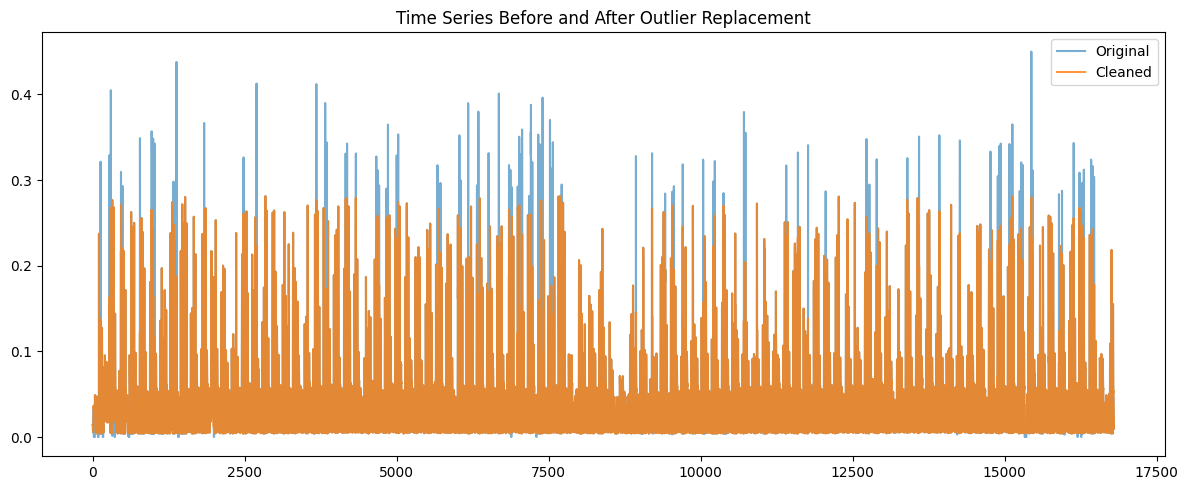

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(df['X'], label='Original', alpha=0.6)
plt.plot(df['X_cleaned'], label='Cleaned', alpha=0.8)
plt.title("Time Series Before and After Outlier Replacement")
plt.legend()
plt.tight_layout()
plt.show()

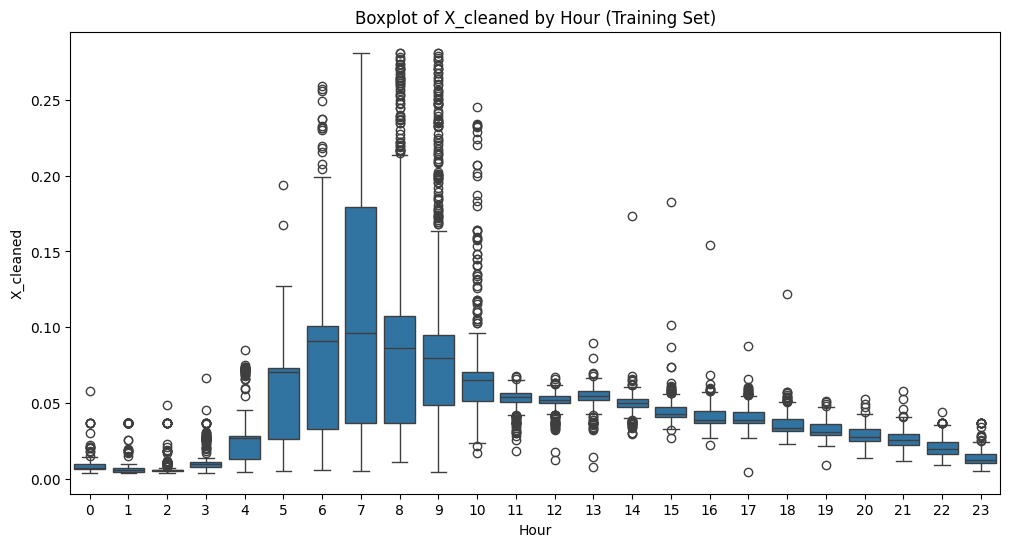

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.iloc[:-744], x=df['Hour'], y=df['X_cleaned'])  # training only
plt.title('Boxplot of X_cleaned by Hour (Training Set)')
plt.xlabel('Hour')
plt.ylabel('X_cleaned')
plt.show()

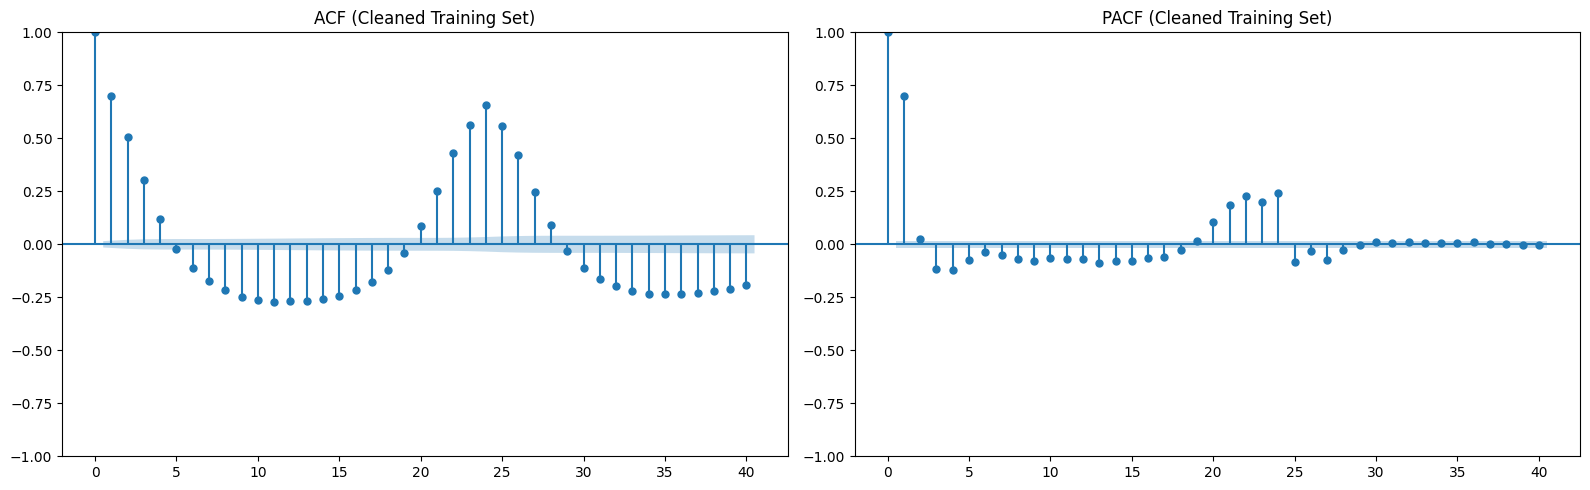

In [14]:
series_cleaned = df.loc[:len(df)-745, 'X_cleaned'].dropna()

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(series_cleaned, lags=40, ax=ax[0])
ax[0].set_title("ACF (Cleaned Training Set)")

plot_pacf(series_cleaned, lags=40, ax=ax[1], method='ywm')
ax[1].set_title("PACF (Cleaned Training Set)")

plt.tight_layout()
plt.show()

In [15]:
adf_result = adfuller(series_cleaned)
print("ADF Test (Cleaned Training Set)")
print(f"ADF Statistic : {adf_result[0]:.4f}")
print(f"p-value       : {adf_result[1]:.4f}")
for key, value in adf_result[4].items():
    print(f"Critical Value {key} : {value:.4f}")


ADF Test (Cleaned Training Set)
ADF Statistic : -16.2884
p-value       : 0.0000
Critical Value 1% : -3.4307
Critical Value 5% : -2.8617
Critical Value 10% : -2.5669
